# <p style="background-color:gray; color:white; font-size:100%; text-align:center; border-radius: 5px 5px;">Unsupervised Semantic Sentiment Analysis of IMDB Reviews</p>

# Table of content 
1. [Introduction](#Introduction)
  >- The problem overview
  >- Importing necessary libraries 
2. [Data Preprocessing](#Preprocessing)
  >- Utility module
  >- `Tokenizer` Calss
  >- Split the Train & Test datasets
  
3. [Supervised Models](#Supervised_Models)

4. [Unsupervised Models](#Unsupervised_Models)
 >- Training the word embedding model
 >- Defining the negative and positive sets
 >- Calculating the semantic sentiment of the reviews
 >- High confidence predictions
 5. [Further Analysis](#Further_Analysis)
 >- sentiment complexity 
 >- A Qualitative Assessment
 >- Now it's your turn!

---
<a id='Introduction'></a>
# 1. Introduction
---

## The problem overview

Sentiment analysis, also called opinion mining, is a common application of Natural Language Processing (NLP) widely used to analyze the overall affect and underlying sentiment of a given sentence or statement. In its most basic form, a sentiment analysis model classifies the text into positive or negative (and sometimes neutral) sentiments. Therefore naturally, the most successful approaches are using supervised models which need a fair amount of labeled data in order to be trained. Providing such data is an expensive and time-consuming process that is not possible or easily accessible in many cases. Additionally, the output of such models is a number implying how similar the text is to the positive examples we provided during the training and does not consider nuances such as the strength of the emotions and sentiment complexity in the text.

Relying on my background in close reading and qualitative analysis of a text, I present an unsupervised semantic sentiment analysis model that not only captures the overall sentiment of the text but also provides a way to analyze the complexity of emotions and subjectivity of the text while maintaining high performance.

To demonstrate this approach, we use the well-known IMDB datebase. Released to the public by [Stanford University](http://ai.stanford.edu/~amaas/data/sentiment/), this dataset is a collection of 50,000 reviews from IMDB that contains an even number of positive and negative reviews with no more than 30 reviews per movie. As it is noted in the dataset introduction document, "a negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset."

The dataset can be obtained from http://ai.stanford.edu/~amaas/data/sentiment/



<a id='Importing_Librares'></a>

## Importing necessary libraries

In [1]:
%%time
# data processing and Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing

import sklearn
from sklearn.model_selection import train_test_split
    
# Libraries and packages for NLP
import nltk 
from gensim.models import Word2Vec


# Visualization 
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['figure.figsize'] = (12, 10)
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'



import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
print('*** --> Modules are imported: ')    
print("Python version:", sys.version)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

print("sklearn version:", sklearn.__version__)
print("nltk version:", nltk.__version__)

*** --> Modules are imported: 
Python version: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
numpy version: 1.19.2
pandas version: 1.1.3
sklearn version: 0.23.2
nltk version: 3.5
CPU times: user 1.6 s, sys: 515 ms, total: 2.11 s
Wall time: 3.3 s


In [2]:
# Importing IMDB Data
df = pd.read_csv('movie_data.csv')

In [3]:
df.head(3)

review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0

In [4]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

---
<a id='Preprocessing'></a>

# 2. Data Preprocessing
---

## Utility module
`NLP_utils` module contains all general utility functions and classes used in multiple places throughout the post. Here is a list of functions and classes in this module:
- Tokenizer class: `Tokenizer`
- Model Evaluation Metrics Function: `model_evaluation_metrics`
- Bag-of-Words CountVectorizer Function: `bow_vectorizer`
- Bag-of-Words Sentiment Analysis Model Training Function: `bow_sentiment_analysis_model_training`
- Word2Vec Model Trainer Function: `w2v_trainer`
- Overall Semantic Similarity Score Function: `overall_similarity_score`
- Overall Semantic Sentiment Analysis Function: `overall_semantic_sentiment_analysis`
- List Similarity Computing Function: `list_similarity`
- TopN Semantic Similarity Score Function: `topn_similarity_score`
- TopN Semantic Sentiment Analysis Function: `topn_semantic_sentiment_analysis`
- Text Semantic Sentiment Analysis Function: `text_SSA`


In [5]:
from NLP_utils import (Tokenizer,
                      model_evaluation_metrics,
                      bow_vectorizer,
                      bow_sentiment_analysis_model_training,
                      w2v_trainer,
                      overall_similarity_score,
                      overall_semantic_sentiment_analysis,
                      list_similarity,
                      topn_similarity_score,
                      topn_semantic_sentiment_analysis,
                      text_SSA)

[nltk_data] Downloading package stopwords to /Users/ahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## `Tokenizer` Calss
For the models we are using in this post, we don't need to break our documents (i.e. reviews) into sentences. So after cleaning and denoising steps, the whole review is broken up into tokens. To easily do so in several ways, I defined the `Tokenizer` class which has the following boolean attributes: `clean`, `lower`, `de_noise`, `remove_stop_words`, and `keep_neagation`. All attributes default to `True`, but we can easily change them to see the effect of different text preprosessing options. By default, this class denoises the text (removing HTML and URL components), convert the text into lowercase, clean the text from all non-alphanumeric characters, and remove stop-words. A nuance here is negation stopwords such as "not" and "no". Negation words are considered as *sentiment shifter* as they often change sentiment of the sentence in the opposite directions (For more on "Negation and Sentiment" see Bing Liu, *Sentiment Analysis: Mining Opinions, Sentiments, and Emotions*, Cambridge University Press 2015, pp. 116-122). If `keep_neagation` is True, the tokenizer will attach the negation tokens to the next token and treat them as a single word before removing the stopwords. Here is an example:

In [6]:
# Create instances and with different attributes
tokenizer1 = Tokenizer(remove_stop_words=True, keep_negation=True)
tokenizer2 = Tokenizer(remove_stop_words=True, keep_negation=False)


# Example statement
statement = "I didn’t like this movie. It wasn't amusing nor visually interesting . I do not recommend it."

# Tokenizing example statement with different Tokenizer instances
print("When tokenizer removes stopwords but keeps negation stopwords: \n", tokenizer1.tokenize(statement))
print("When tokenizer removes all stopwords: \n", tokenizer2.tokenize(statement))

When tokenizer removes stopwords but keeps negation stopwords: 
 ['like', 'movie', 'NOTamusing', 'visually', 'interesting', 'NOTrecommend']
When tokenizer removes all stopwords: 
 ['like', 'movie', 'amusing', 'visually', 'interesting', 'recommend']


Let's now tokenize all out reviews, using this class.

In [7]:
# Instancing the Tokenizer class
tokenizer = Tokenizer(clean= True,
                 lower= True, 
                 de_noise= True, 
                 remove_stop_words= True,
                     keep_negation=True)

# To apply tokenizer to the series (dataframe column)
column_tokenizer = lambda x: tokenizer.tokenize(x)

# Tokenize reviews
df['tokenized_text'] = df['review'].apply(column_tokenizer)

Here are some statistics on the review length

In [8]:
df['tokenized_text_len'] = df['tokenized_text'].apply(lambda x: len(x))
df['tokenized_text_len'].apply(np.log).describe()

count    50000.000000
mean         4.570633
std          0.652155
min          1.098612
25%          4.158883
50%          4.488636
75%          4.983607
max          7.269617
Name: tokenized_text_len, dtype: float64

In [9]:
np.exp(3.9)

49.40244910553017

## Split the Train & Test datasets

In [10]:
y = df['sentiment'] #target
X = df.drop(columns=['sentiment']) #train predictors

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.3,
                                                    stratify=y)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)


X_train shape:  (35000, 3)
y_train shape:  (35000,)
X_test shape:  (15000, 3)


---
<a id ='Supervised_Models'></a>

# 3. Supervised Models 
---
Let's first build a baseline supervised model so that we can compare the results later. Supervised sentiment analysis is basically a classification problem locating documents in two or more classes based on their sentiment affects. It is noteworthy that the assumption of document-level analysis for our problem is that every review only expresses opinions from one reviewer about one product (e.g. a movie or a TV show) because when a document contains different opinions from different people on a single product or different opinions of one person on different products, the classification models can not correctly differentiate between opinions and predict the general sentiment of the document.

As always, the first step is to convert review into feature vectors. I chose frequency Bag-of-Words for this part as a simple yet powerful baseline approach for the text vectorization. Frequency Bag-of-Words assigns a vector to each document with the size of the vocabulary in our corpus, each dimension representing a word. To build the document vector, we fill each dimension with a frequency of occurrence of its respective word in the document. So obviously, most document vectors will be very sparse. To build the vectors, I fitted SKLearn's ‍‍`CountVectorizer‍` on my train set and then used it to transform the test set as well.

In [11]:
%%time
# Import Bag-of-Words CountVectorizer Function
# import bow_vectorizer

# Train/Fit a `CountVectorizer` model with Train dataset
fit_bow_count_vect = bow_vectorizer(X_train['tokenized_text'])

# Create `Bag-of-words` sparse matrix of Train dataset transformed by traind CountVectorizer
X_train_bow_matrix = fit_bow_count_vect.transform(X_train['tokenized_text'])

# Create `Bag-of-words` sparse matrix of Test dataset by transformed by traind CountVectorizerr i.e. `fit_bow_count_vect`
X_test_bow_matrix = fit_bow_count_vect.transform(X_test['tokenized_text'])

print("X_train shape: ", X_train.shape,  "\n X_train_bow_matrix shape: ", X_train_bow_matrix.shape)
print("X_test shape: ", X_test.shape, "\n X_test_bow_matrix shape: ", X_test_bow_matrix.shape)

X_train shape:  (35000, 3) 
 X_train_bow_matrix shape:  (35000, 33076)
X_test shape:  (15000, 3) 
 X_test_bow_matrix shape:  (15000, 33076)
CPU times: user 4.02 s, sys: 119 ms, total: 4.14 s
Wall time: 4.14 s


After vectorizing the reviews, we can use any classification approach to build a sentiment analysis model. I experimented with several models and found a simple logistic regression to be very performative.

In [12]:
%%time
# import bow_sentiment_analysis_model_training
# difine an object to store the trained model
bow_logistreg_model = bow_sentiment_analysis_model_training(X_train_bow_matrix, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.7s remaining:   59.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.5s finished


==> Evaluation Metrics when model applied on Train Data: 
* Accuracy Score:  95.5600%
* F1 Score:  95.5822%
* Recall Score:  96.0629%
* Precision Score:  95.1064%
None
CPU times: user 7.28 s, sys: 425 ms, total: 7.71 s
Wall time: 43.1 s


              precision    recall  f1-score   support

           0     0.9073    0.8916    0.8994      7500
           1     0.8934    0.9089    0.9011      7500

    accuracy                         0.9003     15000
   macro avg     0.9004    0.9003    0.9003     15000
weighted avg     0.9004    0.9003    0.9003     15000



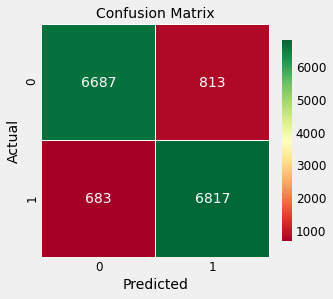

In [13]:
# Predict target value by applying the trained model `bow_logistreg_model`
y_predict_bow_lr = bow_logistreg_model.predict(X_test_bow_matrix)

# Evaluate the model by `model_evaluation_metrics`
model_evaluation_metrics(y_true = y_test, 
                         y_pred = y_predict_bow_lr, 
                         report=True,
                         plot=True)

As you can see the model's F1 score is around 96% on training set and around 90% on the test set. That is a great performance for such a basic approach.

---
<a id='Unsupervised_Approach'></a> 
# 4. Unsupervised Approach
---
After preparing the basics, we can move on to the gist of this post, namely the unsupervised approach to sentiment analysis, which I call Semantic Similarity Analysis (SSA) from now on. In this approach, I first train a word embedding model using the corpus of text we have available. The characteristics of this embedding space is that the similarity between words in this space (Cosine similarity here) is a measure of their semantic relevance. Then we will need two sets of words that are carrying positive and negative sentiments in the context we are working. Now in order to predict the sentiment of a review, we can calculate its similarity to the positive and negative sets and see which sentiment the text is closer to.

## Training the word embedding model
Before going further into the details, let's train the word embedding model. Released in 2013 by Google researchers in this [paper](https://arxiv.org/pdf/1301.3781.pdf), the introduction of word embedding was a game-changer advancement in NLP. As the model converts a word into a vector, it is sometimes called word2vec. I use gensim package to train the wordd2vec method. Since we don't need to split our dataset into Train and Test sets for building unsupervised models, I train the Word2Vec algorithm on all data. 

In [14]:
%%time
# Training a Word2Vec Algorithm ob all data
keyed_vectors_df, keyed_vocab_df = w2v_trainer(df['tokenized_text'])

CPU times: user 3min 28s, sys: 1.79 s, total: 3min 30s
Wall time: 1min 18s


## Defining the negative and positive sets
Now we have a 300 dimensional space in which each word is represented by a vector. In order to come up with the negative and positive sets, I checked the most similar words to the words 'good' and 'bad' and considering the context, I came up with the following lists:

- `positive_concepts` = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
- `negative_concepts` = ['terrible', 'awful', 'horrible', 'boring', 'bad', 'disappointing', 'weak', 'poor',  'senseless', 'confusing']

Please note that we should make sure that all `positive_concepts` and `negative_concepts` are represented in our word2vec model. 

In [15]:
# Find the most similar words to "good" based on word vectors from our trained model
keyed_vectors_df.most_similar('good',topn=15)

[('decent', 0.6366943717002869),
 ('NOTbad', 0.5493144989013672),
 ('NOTgood', 0.521574079990387),
 ('alright', 0.5209722518920898),
 ('great', 0.5165241956710815),
 ('bad', 0.5144324898719788),
 ('fine', 0.4958750605583191),
 ('acceptable', 0.492113322019577),
 ('ok', 0.48841866850852966),
 ('nice', 0.48552849888801575),
 ('okay', 0.4808117151260376),
 ('passable', 0.4607090651988983),
 ('terrific', 0.4597592353820801),
 ('lousy', 0.45271074771881104),
 ('competent', 0.44361865520477295)]

In [16]:
# To make sure that all `positive_concepts` are in the keyed word2vec vocabulary
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab_df]
len(positive_concepts)

10

In [17]:
# Find the most similar words to "bad" based on word vectors from our trained model
keyed_vectors_df.most_similar('bad',topn=15)

[('terrible', 0.608001708984375),
 ('horrible', 0.5901381969451904),
 ('lousy', 0.5865542888641357),
 ('awful', 0.5815596580505371),
 ('atrocious', 0.5489043593406677),
 ('sucks', 0.5189182758331299),
 ('good', 0.5144324898719788),
 ('crappy', 0.5127586126327515),
 ('NOTgood', 0.5022578835487366),
 ('dreadful', 0.4961276650428772),
 ('horrid', 0.48918139934539795),
 ('cheesy', 0.47381916642189026),
 ('NOTbad', 0.46954914927482605),
 ('stupid', 0.46597403287887573),
 ('suck', 0.46300560235977173)]

In [18]:
# To make sure that all `negative_concepts` are in the keyed word2vec vocabulary 
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab_df]
len(negative_concepts)

10

## Calculating the semantic sentiment of the reviews
As we mentioned earlier, in order to predict the sentiment of a review, we need to calculate its similarity to our negative and positive sets. We will call those similarities negative and positive scores respectively. There are several ways to do that. One of the most common approaches is to build the document vector by averaging over the vectors building it. In that way, we will have a vector for every review and two vectors representing our positive and negative sets. The positive and negative scores can then be calculated by a simple cosine similarity between the review vector and the positive and negative vectors respectively. Let's call this approach *Overall Semantic Sentiment Analysis* (**OSSA**).

However, it is a known issue that averaging over all wordvectors in a document is not the best way to build document vectors. Consider a document with 100 words. Most words in that document are so-called glue words that are not contributing to the meaning or sentiment of a document but rather are there to hold the linguistic structure of the text. That means that if we average over all the words, the effect of meaningful words will be reduced by the glue words.

To solve this issue, I define the similarity of a single word to a document, as the average of its similarity with the top_n most similar words in that document. Then I will calculate this similarity for every word in my positive and negative sets and average over to get the positive and negative scores. To put it differently, in order to calculate the positive score for a review, I calculate the similarity of every word in the positive set with all the words in the review, and keep the top_n highest scores for each positive word and then average over all the kept scores. This approach could be called *TopN Semantic Sentiment Analysis* (**TopSSA**).

After calculating the positive and negative scores, we define
    
`semantic_sentiment_score (S3) = positive_sentiment_score (PSS) - negative_sentiment_score (NSS)`

If the S3 is positive, we can classify the review as positive, and if it is negative, we can classify it as negative. Now let's see how such a model performs (The code includes both OSSA and TopSSA approaches, but in this post, only the latter will be explored).


In [19]:
%%time
# To compute Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors_df,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'])

# To compute Semantic Sentiment Scores by TopSSA model
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors_df,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'],
                                                     topn=30)



# To store semantic sentiment store computed by OSSA model in df
df['overall_PSS'] = overall_df_scores[0] 
df['overall_NSS'] = overall_df_scores[1] 
df['overall_semantic_sentiment_score'] = overall_df_scores[2] 
df['overall_semantic_sentiment_polarity'] = overall_df_scores[3]



# To store semantic sentiment store computed by TopSSA model in df
df['topn_PSS'] = topn_df_scores[0] 
df['topn_NSS'] = topn_df_scores[1] 
df['topn_semantic_sentiment_score'] = topn_df_scores[2] 
df['topn_semantic_sentiment_polarity'] = topn_df_scores[3]


CPU times: user 4min 45s, sys: 3.18 s, total: 4min 49s
Wall time: 1min 15s


OSSA Model Evaluation: 
* Accuracy Score:  81.4320%
* F1 Score:  82.6045%
* Recall Score:  88.1720%
* Precision Score:  77.6983%
TopSSA Model Evaluation: 
              precision    recall  f1-score   support

           0     0.8218    0.8716    0.8460     25000
           1     0.8633    0.8110    0.8363     25000

    accuracy                         0.8413     50000
   macro avg     0.8426    0.8413    0.8412     50000
weighted avg     0.8426    0.8413    0.8412     50000



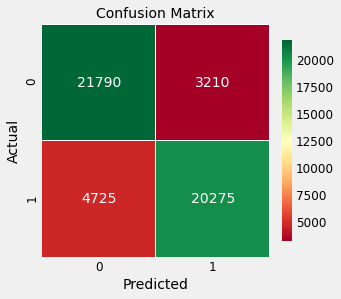

In [20]:

# OSSA Model Evaluation
print("OSSA Model Evaluation: ")
model_evaluation_metrics(df['sentiment'], 
                         df['overall_semantic_sentiment_polarity'])

print("=================")

# TopSSA Model Evaluation
print("TopSSA Model Evaluation: ")
model_evaluation_metrics(df['sentiment'], 
                         df['topn_semantic_sentiment_polarity'], 
                         report=True,
                         plot=True)

As the classification report shows, the TopSSA model manages to achieve better accuracy and F1 scores reaching as high as about 84%, a significant achievement for an unsupervised model. 

Let's visualize the data to understand the results better. In the below scatter plot each review has been placed on the plane based on its PSS and NSS. Therefore, all points above the decision boundary (diagonal blue line) have positive S3 and are then predicted to have a positive sentiment and all points below the boundary have negative S3 and are thus predicted to have a negative sentiment. The actual sentiment labels of reviews are shown by green (positive) and red (negative). It is evident from the plot that most mislabelings happen close to the decision boundary as expected.  

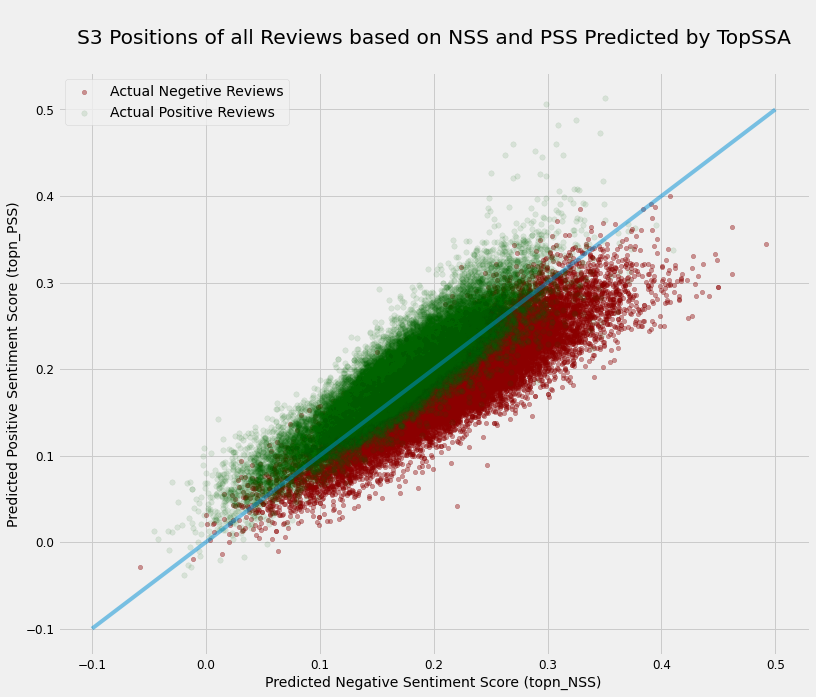

In [21]:
# TopSSA Model
# filter positive and negative review based on Target Variable (actual 'y') or 'sentiment' column
actual_pos_filt = df['sentiment'] == 1
actual_neg_filt =  df['sentiment'] == 0

# filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
predicted_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
predicted_neg_filt = df['topn_semantic_sentiment_polarity'] == 0



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df['topn_NSS'][actual_neg_filt], 
         df['topn_PSS'][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df['topn_NSS'][actual_pos_filt], 
         df['topn_PSS'][actual_pos_filt],  
         label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (topn_NSS)')
plt.ylabel('Predicted Positive Sentiment Score (topn_PSS)')


# plotting the bisector
plt.plot([-0.1,0.5], [-0.1,0.5], alpha=0.5)

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
S3 Positions of all Reviews based on NSS and PSS Predicted by TopSSA
""")

# To save the result in the same folder
plt.savefig('s3_position_all_reviews.png')

plt.show()

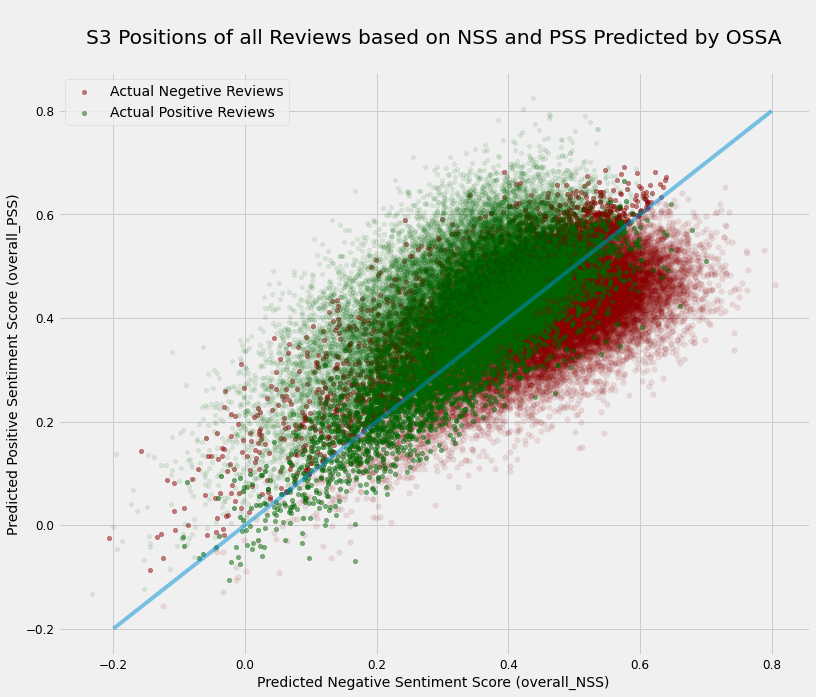

In [22]:

# filter positive and negative review based on Most Probable predicted 'y' or 'overall_semantic_sentiment_score' column
overall_predicted_pos_filt = df['overall_semantic_sentiment_polarity'] == 1
overall_predicted_neg_filt = df['overall_semantic_sentiment_polarity'] == 0

# OSSA Model
# plotting Semantic Sentiment Score Position of Predicted Positive Reviews 
## Predicted Positive but Actual Negative with less transparent red
plt.scatter(df['overall_NSS'][overall_predicted_pos_filt][actual_neg_filt], 
         df['overall_PSS'][overall_predicted_pos_filt][actual_neg_filt],  
         label='Actual Negetive Reviews',
           color='DarkRed',
            alpha=0.5 , # set transparency of color
            s=20 # set size of dots
           )
## Predicted Positive & Actual Positive with more transparent green
plt.scatter(df['overall_NSS'][overall_predicted_pos_filt][actual_pos_filt], 
         df['overall_PSS'][overall_predicted_pos_filt][actual_pos_filt],  
           color='DarkGreen',
            alpha=0.1 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of  Predicted Negative Reviews 
## Predicted Negative & Actual Negative with more transparent red
plt.scatter(df['overall_NSS'][overall_predicted_neg_filt][actual_neg_filt], 
         df['overall_PSS'][overall_predicted_neg_filt][actual_neg_filt],  
       color='DarkRed',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# Predicted Negative but Actual Positive with less transparent green
plt.scatter(df['overall_NSS'][predicted_neg_filt][actual_pos_filt], 
         df['overall_PSS'][predicted_neg_filt][actual_pos_filt],  
         label='Actual Positive Reviews',
           color='DarkGreen',
            alpha=0.5 , # set transparency of color
            s=20 # set size of dots
           )

# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (overall_NSS)')
plt.ylabel('Predicted Positive Sentiment Score (overall_PSS)')


# plotting the bisector
plt.plot([-0.2,0.8], [-0.2,0.8], alpha=0.5)

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
S3 Positions of all Reviews based on NSS and PSS Predicted by OSSA
""")

# To save the result in the same folder
plt.savefig('s3_position_all_reviews.png')

plt.show()

## High confidence predictions
It is well-known that the results further from the decision boundary have better performance. Here I show that this applies to our unsupervised model as well. To do so, I plotted the distribution of the S3, PSS, and NSS for all reviews. As we would expect from Central Limit Theorem, all three distributions are very close to normal with S3 having a mean and std of -0.003918 and 0.037186 respectively. Next, I define the high confidence predictions to be those that their S3 is at least `0.5*std` away from the mean. That consists of ~64% of reviews and the model has the F1 of ~94% for them. 

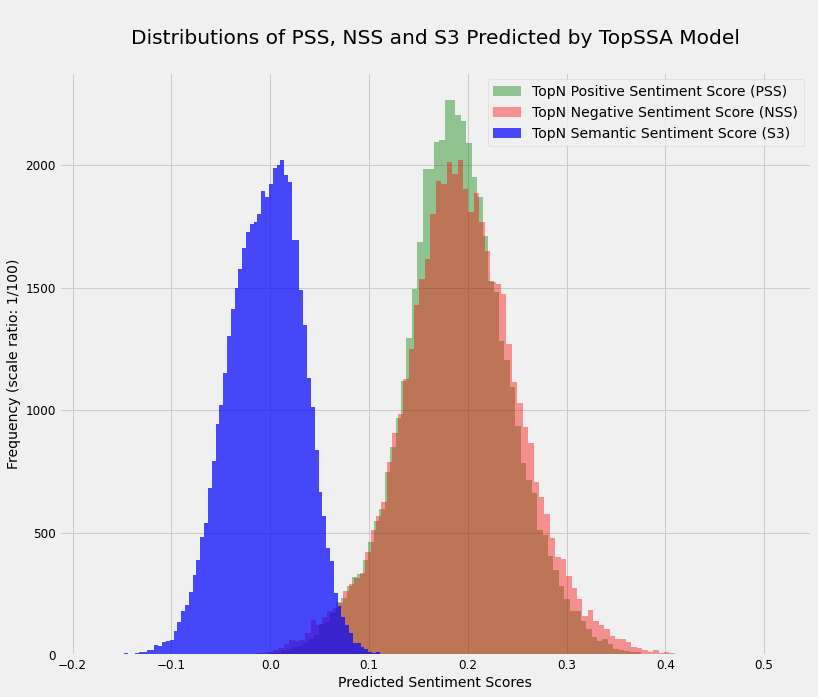

In [23]:
# Plotting Distributions of the PSS, NSS, and S3 Predicted by TopSSA Model
plt.hist(df['topn_PSS'],
        bins=100, color='green', alpha=0.4,
        label= 'TopN Positive Sentiment Score (PSS)')

plt.hist(df['topn_NSS'],
        bins=100, color='red', alpha=0.4,
        label= 'TopN Negative Sentiment Score (NSS)')

plt.hist(df['topn_semantic_sentiment_score'],
        bins=100, color='blue', alpha=0.7,
        label= 'TopN Semantic Sentiment Score (S3)')

# naming the x & y axis
plt.xlabel('Predicted Sentiment Scores')
plt.ylabel('Frequency (scale ratio: 1/100)')

# show a legend on the plot
plt.legend()

plt.title("""
Distributions of PSS, NSS and S3 Predicted by TopSSA Model
""")

# To save the result in the same folder
plt.savefig('pss_nss_s3_Distributions.png')

plt.show()

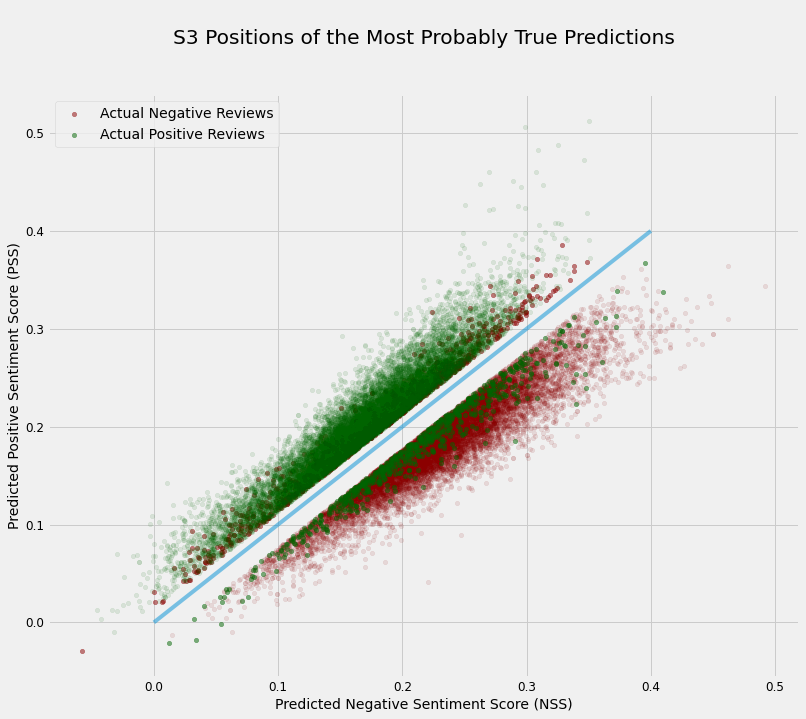

Evaluation Metrics of TopSSA model on the most probable data: 

              precision    recall  f1-score   support

           0     0.9506    0.9240    0.9371     16009
           1     0.9262    0.9520    0.9389     16022

    accuracy                         0.9380     32031
   macro avg     0.9384    0.9380    0.9380     32031
weighted avg     0.9384    0.9380    0.9380     32031



In [24]:
# Filtering the most/the less probably true predictions (TopSSA Model)

# std is standard deviation 
S3_std = df['topn_semantic_sentiment_score'].std()
S3_mean = df['topn_semantic_sentiment_score'].mean()

most_probable_predicted_pos_filt = df['topn_semantic_sentiment_score'] >= (S3_mean + 0.5*S3_std)
most_probable_predicted_neg_filt = df['topn_semantic_sentiment_score'] <= (S3_mean - 0.5*S3_std)

# to create the most probable dataframe:
df_most_probable = pd.concat([df[most_probable_predicted_pos_filt], 
                              df[most_probable_predicted_neg_filt]], axis=0)

# plotting Semantic Sentiment Score Position of Most Probable Predicted Positive:
# Predicted Positive but Actual Negative
plt.scatter(df['topn_NSS'][most_probable_predicted_pos_filt][actual_neg_filt], 
         df['topn_PSS'][most_probable_predicted_pos_filt][actual_neg_filt],  
         label='Actual Negative Reviews',
       color='DarkRed',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# Predicted Positive & Actual Positive 
plt.scatter(df['topn_NSS'][most_probable_predicted_pos_filt][actual_pos_filt], 
         df['topn_PSS'][most_probable_predicted_pos_filt][actual_pos_filt],  
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Most Probable Predicted Negative Reviews
# Predicted Negative & Actual Negative
plt.scatter(df['topn_NSS'][most_probable_predicted_neg_filt][actual_neg_filt], 
         df['topn_PSS'][most_probable_predicted_neg_filt][actual_neg_filt],  
       color='DarkRed',
            alpha=0.1, # set transparency of color
            s=20 # set size of dots
           )

# Predicted Negative but Actual Positive 
plt.scatter(df['topn_NSS'][most_probable_predicted_neg_filt][actual_pos_filt], 
         df['topn_PSS'][most_probable_predicted_neg_filt][actual_pos_filt],
            label='Actual Positive Reviews',
       color='DarkGreen',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (NSS)')
plt.ylabel('Predicted Positive Sentiment Score (PSS)')

# plotting the bisector
plt.plot([0,0.4], [0,0.4], alpha=0.5)

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
S3 Positions of the Most Probably True Predictions

""")

# To save the result in the same folder
plt.savefig('s3_positions_most_probably_true_predictions.png')

plt.show()

# Evaluation Metrics 
print('Evaluation Metrics of TopSSA model on the most probable data: \n')
model_evaluation_metrics(df_most_probable['sentiment'], 
                         df_most_probable['topn_semantic_sentiment_polarity'],
                        report=True)

Now the problem is how to filter the instances placed on the wrong side of the given decision boundary. This filter provides the most probably correct predictions. To do so, it is enough to take distance from the average of `topn_semantic_sentiment_score` by about 0.5 standard deviation. The following code shows that more than 64% of the reviews belongs to the most probable prediction group. The accuracy score of the TopSSA model on the most probable data increases to about 94%. Saving time and cost, this method could be employed for a massive data labeling. 

---
<a id='Further_Analysis'></a> 
# 5. Further Analysis
---

So far, I showed how a simple unsupervised model can perform very well on a sentiment analysis task. As I promised in the introduction, now I will show how this model will be able to provide additional valuable information that supervised models are not providing. Namely, I will show that this model can give us an understanding of the sentiment complexity of the text. To do so, I will again rely on our positive and negative scores. But first, let's look into another property of those scores. In addition to the fact that both scores are normally distributed, the value of both scores is correlated with the length of the review. Namely, the longer the review, the higher its negative and positive scores. A simple explanation is that with more words, one can potentially express more positive or negative emotions. Of course, the scores cannot be more than 1 and they saturate eventually (around 0.35 here). The below plot shows the correlation very well. Please note that in order to better depict this for both sets of scores, I reversed the sign of negative scores. 

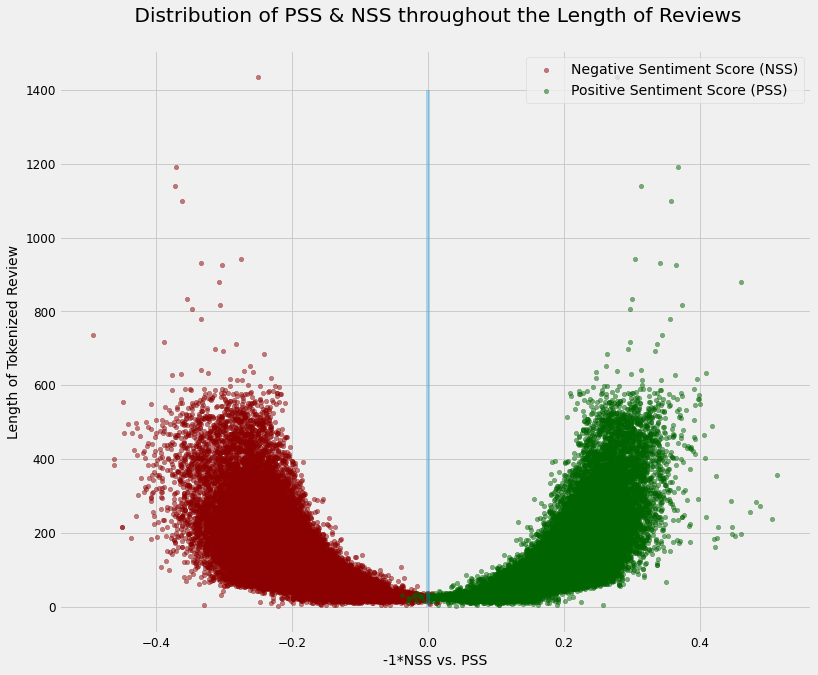

In [25]:
# To plot the relationship between length of review and its Semantic Sentiment Score
# to plot Negative Score Position of all Reviews
plt.scatter(-df['topn_NSS'], 
            df['tokenized_text_len'],
            label='Negative Sentiment Score (NSS)',
            color='DarkRed',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# to plot Positive Score Position of all Reviews
plt.scatter(df['topn_PSS'], 
            df['tokenized_text_len'],  
            label='Positive Sentiment Score (PSS)',
            color='DarkGreen',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# naming the x & y axis
plt.xlabel('-1*NSS vs. PSS')
plt.ylabel('Length of Tokenized Review')

# plotting the bisector
plt.plot([0,0], [0,1400], alpha=0.3) 

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title(""" Distribution of PSS & NSS throughout the Length of Reviews
""")

# To save the result in the same folder
plt.savefig('pss_nss_distribution_throughout_length.png')


plt.show()


Therefore to account for the effect of text length in our analysis, we slice the dataset so that reviews placed in each subset would be close in length. In this post, I limit the analysis to the reviews between 100 to 140 tokens (the average number of tokens in reviews is 120). The F1 score for this slice of the dataset is ~83%, which is close to the F1 score on the whole dataset. Additionally, both positive and negative scores in this slice also have a normal distribution with the following values:

> PSS_mean = 0.200648  
> PSS_std = 0.031200

> NSS_mean = 0.205617  
>NSS_std = 0.039358 

In [26]:
df_slice = df[df["tokenized_text_len"].between(100,140)]
len(df_slice)

8395

In [27]:
model_evaluation_metrics(df_slice["sentiment"] , 
                         df_slice["topn_semantic_sentiment_polarity"],
                        report=True)

              precision    recall  f1-score   support

           0     0.8206    0.8661    0.8427      4330
           1     0.8484    0.7983    0.8226      4065

    accuracy                         0.8332      8395
   macro avg     0.8345    0.8322    0.8326      8395
weighted avg     0.8340    0.8332    0.8329      8395



## Sentiment Complexity

My main claim here is that we can assess the sentiment complexity (or complexity of emotions) of a text using their PSS and NSS. I will show that if a text has simultaneously high PSS and high NSS (low S3), it may have a high sentiment complexity. And if the text obtains low PSS and high NSS or vice versa (high S3) it may be considered as low sentiment complexity. But, first let's define what is high and low. For the sake of this analysis we define very high and very low PSS (NSS) to be values with above and below two standard deviation from their mean respectively. Then, high, mid, and low PSS (NSS) are placed between these two levels. So

- Very High PSS(NSS) = PSS(NSS) > mean_PSS(NSS) + 2*std_PSS(NSS)
- High PSS(NSS) = PSS(NSS) > mean_PSS(NSS) + std_PSS(NSS)
- Mid PSS(NSS) = mean_PSS(NSS) - std_PSS(NSS)  < PSS(NSS) < mean_PSS(NSS) + std_PSS(NSS)
- Low PSS(NSS) = PSS(NSS) < mean_PSS(NSS) - std_PSS(NSS)
- Very Low PSS(NSS) = PSS(NSS) < mean_PSS(NSS) - 2*std_PSS(NSS)

Accordingly, we can define high, mid, and low sentiment complexity as:

- High sentiment complexity = High PSS & High NSS
- Mid sentiment complexity = (Very High PSS & Mid NSS) or (Very High NSS & Mid PSS)
- Low sentiment complexity = (High PSS & Low NSS) or (High NSS & Low PSS)


In [28]:
PSS_mean = df_slice["topn_PSS"].mean()
PSS_std = df_slice["topn_PSS"].std()
NSS_mean = df_slice["topn_NSS"].mean()
NSS_std = df_slice["topn_NSS"].std()


# Very High PSS(NSS)
very_high_PSS = df_slice["topn_PSS"] > PSS_mean + 2*PSS_std
very_high_NSS = df_slice["topn_NSS"] > NSS_mean + 2*NSS_std

# High PSS(NSS)
high_PSS = df_slice["topn_PSS"] > PSS_mean + PSS_std
high_NSS = df_slice["topn_NSS"] > NSS_mean + NSS_std

# Mid PSS(NSS)
mid_PSS = df_slice["topn_PSS"].between(PSS_mean - PSS_std, PSS_mean + PSS_std)
mid_NSS = df_slice["topn_NSS"].between(NSS_mean - NSS_std, NSS_mean + NSS_std)

# Low PSS(NSS)
low_PSS = df_slice["topn_PSS"] < PSS_mean - PSS_std
low_NSS = df_slice["topn_NSS"] < NSS_mean - NSS_std

# Very Low PSS(NSS)
very_low_PSS = df_slice["topn_PSS"] < PSS_mean - 2*PSS_std
very_low_NSS = df_slice["topn_NSS"] < NSS_mean - 2*NSS_std


# # Very High sentiment complexity
# very_high_complexity = very_high_PSS & very_high_NSS
# df_slice_very_high_complexity = df_slice[very_high_complexity]
# print("Number of reviews with very high sentiment complexity: ", len(df_slice_very_high_complexity))
# model_evaluation_metrics(df_slice_very_high_complexity["sentiment"] , 
#                          df_slice_very_high_complexity["topn_semantic_sentiment_polarity"])


# High sentiment complexity
high_complexity = high_PSS & high_NSS
df_slice_high_complexity = df_slice[high_complexity]
print("\n Number of reviews with high sentiment complexity: ", len(df_slice_high_complexity))
model_evaluation_metrics(df_slice_high_complexity["sentiment"] , 
                         df_slice_high_complexity["topn_semantic_sentiment_polarity"])

# Mid sentiment complexity
mid_complexity_pos = very_high_PSS & mid_NSS
mid_complexity_neg = very_high_NSS & mid_PSS
mid_complexity = mid_complexity_pos | mid_complexity_neg
df_slice_mid_complexity = df_slice[mid_complexity]
print("\n Number of reviews with mid sentiment complexity: ", len(df_slice_mid_complexity))
model_evaluation_metrics(df_slice_mid_complexity["sentiment"], 
                         df_slice_mid_complexity["topn_semantic_sentiment_polarity"])

# low sentiment complexity
low_complexity = (very_high_PSS & low_NSS) | (very_high_NSS & low_PSS)
df_slice_low_complexity = df_slice[low_complexity]
print("\n Number of reviews with low sentiment complexity: ", len(df_slice_low_complexity))
model_evaluation_metrics(df_slice_low_complexity["sentiment"] , 
                         df_slice_low_complexity["topn_semantic_sentiment_polarity"])



 Number of reviews with high sentiment complexity:  431
* Accuracy Score:  84.2227%
* F1 Score:  58.5366%
* Recall Score:  61.5385%
* Precision Score:  55.8140%

 Number of reviews with mid sentiment complexity:  283
* Accuracy Score:  96.8198%
* F1 Score:  96.8198%
* Recall Score:  100.0000%
* Precision Score:  93.8356%

 Number of reviews with low sentiment complexity:  1
* Accuracy Score:  100.0000%
* F1 Score:  100.0000%
* Recall Score:  100.0000%
* Precision Score:  100.0000%


On the other side of complexity, there is a group of reviews that have simultaneously low PSS and low NSS. These reviews often state Less opinion and more fact, so they could be called reviews with less subjectivity, and be quantitatively defined as: 
speaking, strong sentiment can be defined as such:

- Low Subjectivity = low PSS & low NSS 

In [29]:
# low subjectivity
low_subjectivity = low_PSS & low_NSS
df_slice_low_subjectivity = df_slice[low_subjectivity]
print("\n Number of reviews with less subjectivity: ", len(df_slice_low_subjectivity))
model_evaluation_metrics(df_slice_low_subjectivity["sentiment"] , 
                         df_slice_low_subjectivity["topn_semantic_sentiment_polarity"])



 Number of reviews with less subjectivity:  613
* Accuracy Score:  66.2316%
* F1 Score:  74.6012%
* Recall Score:  70.8625%
* Precision Score:  78.7565%


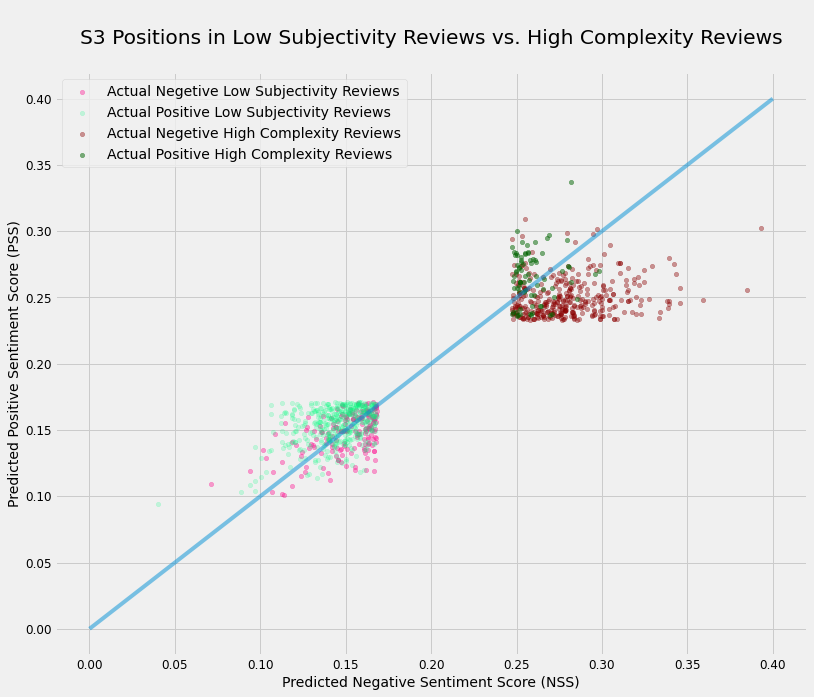

In [30]:
# TopSSA Model
# filter positive and negative review based on Target Variable (actual 'y') or 'sentiment' column
actual_pos_filt = df_slice_high_complexity['sentiment'] == 1
actual_neg_filt =  df_slice_high_complexity['sentiment'] == 0

# # filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
# predicted_pos_filt = df_slice_high_complexity['topn_semantic_sentiment_polarity'] == 1
# predicted_neg_filt = df_slice_high_complexity['topn_semantic_sentiment_polarity'] == 0

actual_pos_low_subjectivity = df_slice_low_subjectivity['sentiment'] == 1
actual_neg_low_subjectivity = df_slice_low_subjectivity['sentiment'] == 0

# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df_slice_low_subjectivity['topn_NSS'][actual_neg_low_subjectivity], 
         df_slice_low_subjectivity['topn_PSS'][actual_neg_low_subjectivity],  
         label='Actual Negetive Low Subjectivity Reviews',
           color='deeppink',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df_slice_low_subjectivity['topn_NSS'][actual_pos_low_subjectivity], 
         df_slice_low_subjectivity['topn_PSS'][actual_pos_low_subjectivity],  
         label='Actual Positive Low Subjectivity Reviews',
       color='springgreen',
            alpha=0.2, # set transparency of color
            s=20 # set size of dots
           )



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df_slice_high_complexity['topn_NSS'][actual_neg_filt], 
         df_slice_high_complexity['topn_PSS'][actual_neg_filt],  
         label='Actual Negetive High Complexity Reviews',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df_slice_high_complexity['topn_NSS'][actual_pos_filt], 
         df_slice_high_complexity['topn_PSS'][actual_pos_filt],  
         label='Actual Positive High Complexity Reviews',
       color='DarkGreen',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Predicted Negative Sentiment Score (NSS)')
plt.ylabel('Predicted Positive Sentiment Score (PSS)')


# plotting the bisector
plt.plot([0,0.4], [0,0.4], alpha=0.5)

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
S3 Positions in Low Subjectivity Reviews vs. High Complexity Reviews
""")

# To save the result in the same folder
plt.savefig('s3_positions_in_low_subjectivity_vs_high_complexity_reviews.png')

plt.show()

Although for both the high sentiment complexity group and low subjectivity group, the S3 doesn't fall necessarily around the decision boundary, yet -for different reasons- it is hard for our model to predict their sentiment correctly. Traditional classification models cannot differentiate between these two groups, but our approach provides us with that extra information. The following plots show the distribution of the S3 in each group (only for `df_slice` dataset). To read the reviews, hover over the points. 

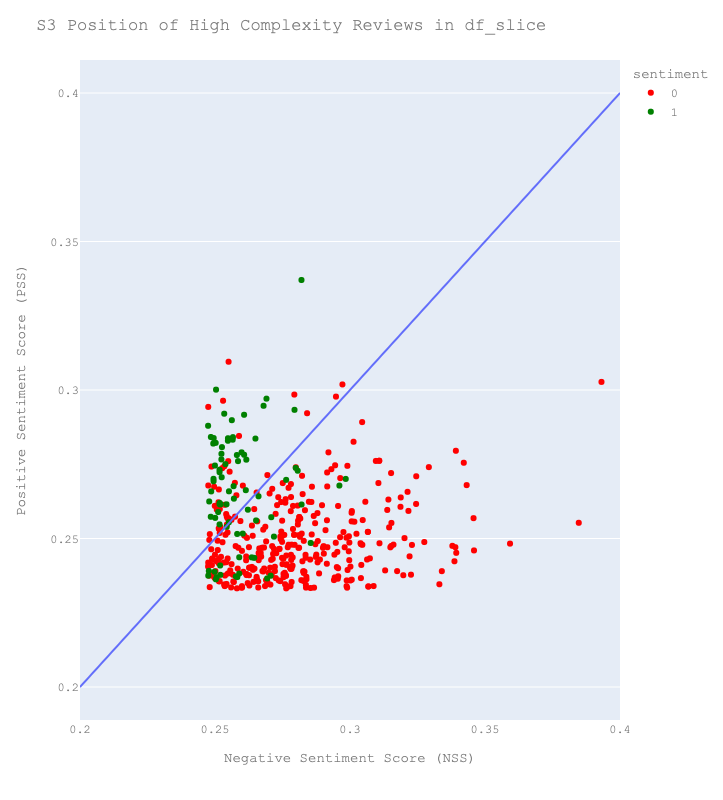

In [31]:
text_high_complexity = df_slice_high_complexity['review'].str.wrap(100).str.replace("\n", "<br>"),

fig = px.strip(df_slice_high_complexity, 
               x= "topn_NSS", 
               y="topn_PSS",
               color= "sentiment",
               color_discrete_sequence=['red','green'],
               hover_name = "tokenized_text_len",
               hover_data=text_high_complexity,
               height=800,
               width=800)

fig.update_layout(
   title = "S3 Position of High Complexity Reviews in df_slice",
   xaxis_title = "Negative Sentiment Score (NSS)",
   yaxis_title = "Positive Sentiment Score (PSS)",
   font = dict(
      family = "Courier New, monospace",
      size = 12,
      color = "#7f7f7f"
   )
)

fig.add_trace(px.line(x=[0.2,0.4], y=[0.2,0.4]).data[0])
fig.show()


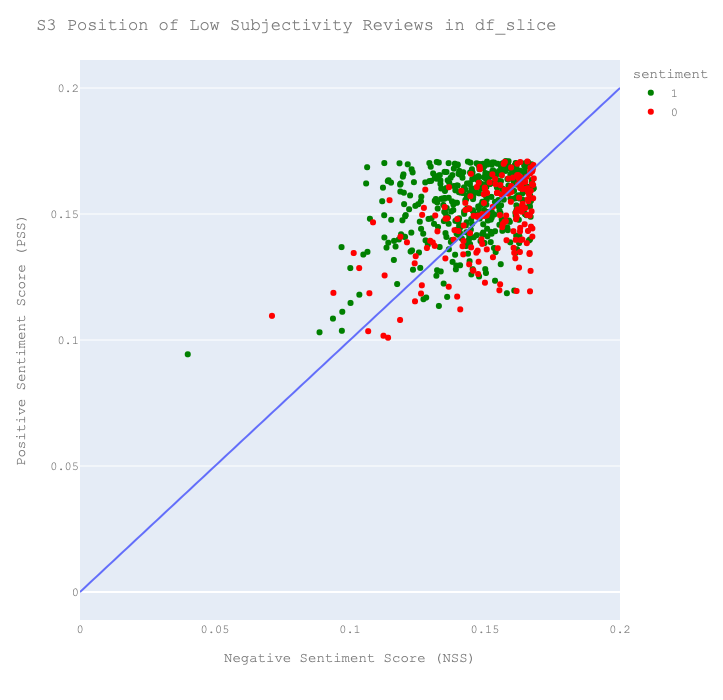

In [32]:
text_less_subjectivity = df_slice_low_subjectivity['review'].str.wrap(100).str.replace("\n", "<br>"),


fig = px.strip(df_slice_low_subjectivity, 
               x= "topn_NSS", 
               y="topn_PSS",
               color= "sentiment",
               color_discrete_sequence=['green','red'],
               hover_name = "tokenized_text_len",
               hover_data=text_less_subjectivity,
               height=700,
               width=700)

fig.update_layout(
   title = "S3 Position of Low Subjectivity Reviews in df_slice",
   xaxis_title = "Negative Sentiment Score (NSS)",
   yaxis_title = "Positive Sentiment Score (PSS)",
   font = dict(
      family = "Courier New, monospace",
      size = 12,
      color = "#7f7f7f"
   )
)

fig.add_trace(px.line(x=[0,0.2], y=[0,0.2]).data[0])
fig.show()


## A Qualitative Assessment

In the rest of this post, I will qualitatively analyze a couple of reviews from the high complexity group  to support my claim that sentiment analysis is a complicated intellectual task even for the human brain.

Although NLP is never concerned with relation between intention and convention in a way that this issue is addressed in theory of meaning and philosophy of language, we can not ignore that one may use words with an intention of meaning or sentiment that differs from the ordinary usages of the words. For instance, we may sarcastically use a word, which is often considered positive in convention of communication to express our negative opinion. A sentiment analysis model can not notice this sentiment shift if it did not learn how to use contextual indications to predict sentiment intended by the author. To illustrate this point let's see review **#46798** which has minimum S3 in the high complexity group. Starting with the word "Wow" which is the exclamation of surprise, often used for expressing astonishment or admiration, the review seems to be a positive one. The reviewer paradoxically repeats that bad films are entertaining. But the model successfully captured the negative sentiment expressed with irony and sarcasm. 

Another reason behind the sentiment complexity of a text is to express different emotions about different aspects of the subject so that the general sentiment of the text would not be clearly grasped. An instance is review  **#21581** that has the highest S3 in the group of high sentiment complexity. The review starts with the story of the film which is, according to the reviewer, "so stupid" and "a poor joke, at best". But soon after that, the complexity appears by stating positive and negative aspects of the film using several *sentiment shifters* such as 'not', 'but' and 'however'. Overall the film is 8/10 in the reviewer's opinion and the model managed to predict this positive sentiment despite all complex emotions expressed in this short text. In contrast,  review **#29090** is an example of the model's error. The review is strongly negative and clearly expresses disappointment and anger about the ratting and publicity that the film gained undeservedly. However, the model failed to predict the sentiment. Apparently, because the review vastly includes other people's positive opinions on the movie as well as the reviewer's positive emotions on other movies.

Similarly interesting, review **#16858** dramatically combines complex emotions about the film. The reviewer used to love the film and watched it over and over when he was a kid. Watching the film as a grown-up, his experience, however, isn't as great as he remembered: the acting, the storyline, the jokes look "pretty bad". No one can be sure about the reviewer's final decision between these two completely opposite sentiments. And surprisingly he decides to appreciate his childhood and gives it 7 stars. No wonder that the model failed to recognize the power of nostalgia.

To be fair, we must admit that sometimes our manual labeling is also not accurate enough. An impressive example is review **#46894** which is labeled as negative but the reviewer explicitly spells out that "I give the show a six". Please note that the dataset introduction document claims that reviews with scores 5 and 6 are considered neutral and not included in the dataset. Nevertheless, our model accurately classified this review as positive although in model evaluation we had to count it as a false positive prediction. 

In [33]:
# To select False Positive & False Negative predictions
true_pos = df_slice_high_complexity["sentiment"] == 1 
true_neg = df_slice_high_complexity["sentiment"] == 0 

pred_pos = df_slice_high_complexity["topn_semantic_sentiment_polarity"] == 1
pred_neg = df_slice_high_complexity["topn_semantic_sentiment_polarity"] == 0

false_pos = pred_pos & true_neg
false_neg = pred_neg & true_pos

print("* False Positive predictions: \n", df_slice_high_complexity[false_pos]["review"])
print("* False Negative predictions: \n", df_slice_high_complexity[false_neg]["review"]);

* False Positive predictions: 
 2497     Although I have enjoyed Bing Crosby in other m...
3956     The premise of this movie, of a comedian talk ...
6803     I rented this movie because I love Kristanna L...
9359     i had gone to the movies expecting to see a gr...
11122    I expected a lot more out of this film. The pr...
12749    Ravi Chopra wrote this film 40 years back, wan...
12911    If you really have to watch this movie because...
14042    I really wanted to like this movie. The previe...
16406    I have watched this movie a few times and neve...
16894    Okay, I'm sorry to the cast and crew for this ...
17271    Come on Tina Fey you can do better then this. ...
19058    i am working at a video store so i got to see ...
22509    After coming off the first one you think the w...
22587    The original 1965 Japanese film "Gamera" http:...
24426    I saw this with high expectations. Come on, it...
25597    This movie had the potential to be a very good...
28736    Don't be taken 

**Review #46798 (True Negative Prediction):**
- `topn_PSS` = 0.297876
- `topn_NSS` = 0.389544
- `topn_semantic_sentiment_score` = -0.0916676 

> "Wow. As soon as I saw this movie\'s cover, I immediately wanted to watch it because it looked so bad. Sometimes I watch Bollywood movies just because they\'re so bad that it will be entertaining (eg. Koi Mil Gaya). This movie had all the elements of an atrocious film: a "gang of local thugs" that is completely harmless, a poorly done motorcycle scene, horrible dialouge ("Congrats son, I am very proud that you are a Bad Boy"), actors playing basketball as if they are good, atrocious songs ("Me bad, me bad, me bad bad boy"), unexplained plot lines like why are the Good Boy and Bad Boy friends??? And why is the hot girl in love with the nerd?? I\'ve never seen such a poorly constructed story with such horrible directly. Some of the scenes actually took 30 seconds long like the one where the Good and Bad Boys inexplicably ran over the "gang member\'s" poker game. Congrats Ashwini Chaudry, you are a Bad Director. If you want to watch a good movie, watch Guru, if you want to watch a movie so bad that it\'s actually entertaining, then watch Good Boy, Boy."

**Review #21581 (True Positive Prediction):**
- `topn_PSS` = 0.260054
- `topn_NSS` = 0.247708
- `topn_semantic_sentiment_score` = 0.0123464

> "The plot: A crime lord is uniting 3 different mafias in an entreprise to buy an island, that would then serve as money-laundering facility for organized crime. To thwart that, the FBI tries to bust one of the mafia lords. The thing goes wrong, and by some unlikely plot twists and turns, we are presented with another "cop buddies who don\'t like each other" movie... one being a female FBI agent, and the other a male ex-DEA agent.<br /><br />So far, so stupid. But the strength of this movie does not lie in its story - a poor joke, at best. It is funny. (At least the synchronized German version is). The action is good, too, with a memorable scene involving a shot gun and a rocket launcher. But the focus is squarely on the humour. Not intelligent satire, not quite slapstick, but somewhere in between, you get a lot of funny jokes. <br /><br />However, this film is the opposite of political correctness. Legal drug abuse is featured prominently, without criticism, and even displaying it as cool. That\'s the bit of the movie that seriously annoyed me, and renders it unsuitable for kids, in my opinion. <br /><br />All in all, for a nice evening watching come acceptable action with some funny jokes, this movie is perfect. Just remember: In this genre, it is common to leave your brain at the door when you enter the cinema / TV room. Then you\'ll have a good time. 8/10"

**Review #29090 (False Positive Prediction):**

- `topn_PSS` = 0.254718
- `topn_NSS` = 0.252167
- `topn_semantic_sentiment_score` = 0.00255111

> "How this film gains a 6.7 rating is beyond belief. It deserves nothing better than a 2.0 and clearly should rank among IMDb\'s worst 100 films of all time. National Treasure is an affront to the national intelligence and just yet another assault made on American audiences by Hollywood. Critics told of plot holes you could drive a 16 wheeler through.<br /><br />I love the justifications for this movie being good... "Nicholas Cage is cute." Come on people, no wonder people around the world think Americans are stupid. This has to be the most stupid, insulting movie I have ever seen. If you wanted to see an actually decent film this season, consider Kinsey, The Woodsman, Million Dollar Baby or Sideways. National Treasure unfortunately got a lot more publicity than those terrific films. I bet most of you reading this haven\'t even heard of them, since some haven\'t been widely released yet.<br /><br />Nicholas Cage is a terrific actor - when he is in the right movies. Time after time I\'ve seen Cage waste his terrific talent in awful mind-numbing films like Con Air, The Rock and Face-Off. When his talent is put to good use like in Charlie Kaufman\'s Adaptation he is an incredible actor.<br /><br />Bottom line - I\'d rather feed my hand to a wood chipper than be subjected to this visual atrocity again."

**Review #16858 (False Negative Prediction):**
- `topn_PSS` = 0.251645
- `topn_NSS` = 0.256545
- `topn_semantic_sentiment_score` = -0.0048998

>"Yes, I loved this movie when I was a kid. When I was growing up I saw this movie so many times that my dad had to buy another VHS copy because the old copy had worn out.<br /><br />My family received a VHS copy of this movie when we purchased a new VHS system. At first, my mom wasn't sure that this was an appropriate movie for a 10 year old but because we had just bought a new VHS system she let me watch it.<br /><br />Like I said, this movie is every little boys dream The movie contains a terrific setting, big muscled barbarians, beautiful topless women, big bad monsters and jokes you'll only get when you get older. So, a couple of days ago I inserted the video and watched the movie again after a long time. At first, I was bored, then started thinking about how much I loved this movie when I was kid, and continued watching. Yeah, the experience wasn't as great as I remembered The acting is pretty bad, the storyline is pretty bad, the jokes weren't funny anymore, but the women were still pretty. Yes, I've grown up. Even though the movie experience has changed for me, I still think it's worth 7 stars. For the good old times you know"

**Review #46894 (Positive Prediction, wrongly labeled as Negative)**:
- `topn_PSS` = 0.286535
- `topn_NSS` = 0.211566
- `topn_semantic_sentiment_score` = 0.0749689
>"I give the show a six because of the fact that the show was in fact a platform for Damon Wayans as the Cosby Show was for Bill Cosby, it dealt with a lot of issues with humor and I felt that it in fact tailored to getting a laugh as opposed to letting the jokes come from the character. <br /><br />Michael Kyle An interesting patriarch and a wisecracking person. He is PHENOMENAL in movies, but in the show he was there for the wisecrack and though I loved it, I felt that the laugh was more important than plausibility.<br /><br />Jay Kyle I have loved her since House Party and have enjoyed her in School Daze and Martin, this was a great role for her and she made a great choice in picking this sitcom to co-star in. I also feel that Jay and Michael were more like equals in the show but Jay was more the woman who fed her crazy husbands the lines and went along with his way of unorthodox discipline because she may have felt that it worked<br /><br />Jr Just plain stupid, his character should have been well developed and even though he does have his moments of greatness, we are returned to the stupidity as if he learned nothing, which drives me nuts!!!!!!!! Not to mention that most of the situations (in episodes I've seen) seems to center around him<br /><br />Clair The attractive sister who dated a Christian, I found her boyfriend's character to be more interesting than she was (she'd be better off sticking to movies, the writers should have done more to show her intelligence but it's not stereotypical enough)<br /><br />Kady Lovable and the youngest daughter. I think the writers established her character most on the show aside from the parents and Franklin<br /><br />Franklin I LOVE this character and I think they derived it from Smart Guy (T.J. Mowry) which only lasted one season. They did a great job of casting for this little genius (the effort would have been made if Jr would have been the smart one but show the down sides also)<br /><br />All in all, this sitcom is a wonderful thing and it's homage to the Cosby Show is well done, I love the show and wished it would have stayed on longer than that. I can't wait to see the series finale"

### Now it's your turn
Let's have fun with the *Text Semantic Sentiment Analysis* function. Share your opinion with the TopSSA model and explore how accurate is it in analyzing the sentiment.

In [ ]:
text_SSA(keyed_vectors=keyed_vectors_df,
              tokenizer=tokenizer,
              positive_target_tokens=pos_concepts,
              negative_target_tokens=neg_concepts,
              topn=30)